<h2><center><font color="black"><strong>Test d'algorithme sur Marseille</strong></font></center></h2>

In [3]:
import pandas as pd
import numpy as np
import zipfile
#from pandas_profiling import ProfileReport

import datetime, warnings, scipy 
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#from mpl_toolkits.basemap import Basemap

import warnings
warnings.filterwarnings(action='once')
pd.set_option('display.max_columns', None)

In [4]:
import itertools
import scipy 
import sklearn
from sklearn import ensemble, tree, metrics, preprocessing
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
#ridge, lasso a ajouter ?
from sklearn.datasets import make_regression

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import MaxAbsScaler, StandardScaler, MinMaxScaler
from sklearn.metrics import balanced_accuracy_score, make_scorer, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error , r2_score
from sklearn.model_selection import train_test_split, GridSearchCV

#### Import de la base

In [6]:
df = pd.read_csv('../../Data/temp_marseille.csv', low_memory = False)

In [7]:
%run '../../Helpers/preprocessing.py'

#### Visualisation de la base

In [39]:
df.head(4)

,id_mutation,date_mutation,code_type_local,code_commune,surface_terrain,surface_reelle_bati,nombre_pieces_principales,valeur_fonciere,latitude,longitude,nombre_lots,Prix_m2,Year,Month,prix_m2_moy_surf_habit,prix_m2_moy_terrain,trimestre,num_trimestre,quarter,Prix_m2_log
0,2021-140088,2021-01-04,2.0,13204,0.0,54.0,2.0,145000.0,43.306456,5.395921,2,2685.185185,2021,1,2721.717306,12027.867705,1,1,2021_Q1,7.895505
1,2021-140089,2021-01-05,2.0,13204,0.0,72.0,3.0,177000.0,43.300456,5.400364,1,2458.333333,2021,1,2721.717306,12027.867705,1,1,2021_Q1,7.807239
2,2021-140094,2021-01-05,2.0,13204,0.0,84.0,2.0,218000.0,43.300533,5.390567,2,2595.238095,2021,1,2721.717306,12027.867705,1,1,2021_Q1,7.861434
3,2021-140097,2021-01-05,2.0,13204,0.0,65.0,4.0,130000.0,43.301224,5.403618,1,2000.000000,2021,1,2721.717306,12027.867705,1,1,2021_Q1,7.600902


## <center> Définition des fonctions utiles

In [ ]:
# Mettre en log les variables continues

In [37]:
def log_var(data, liste_var) : 
    for variable in liste_var :
        new_variable = variable + '_log'
        data[new_variable] = np.log(data[variable])

In [ ]:
# Normaliser les données

In [ ]:
# Créer les variables Annee-Trimestre

In [31]:
def annee_trimestre(data) : 
        # Mettre le format date
    data['date_mutation'] = pd.to_datetime(data['date_mutation'], format = '%Y-%m-%d')
        # num_trimestre indique le trimestre de la date mutation ie 1, 2, 3 ou 4
    data['num_trimestre'] = data['date_mutation'].dt.quarter
        # Concaténation sous la forme YEAR-Qi
    data['quarter'] = data['Year'].astype(str) + '_Q' + data['trimestre'].astype(str)

In [ ]:
# Pour le split temporel à actualiser (ie prendre t-1)

In [ ]:
# Pour le modèle

In [34]:
def split_temporel(data, liste_features, liste_output) :
    data = data.sort_values('date_mutation')
    X = data[liste_features]
    y = data[liste_output]
    
    # Shuffle = False pour garder les dernières obs en test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=False)
    return(X_train, X_test, y_train, y_test)

In [5]:
# Pour utiliser les Knn

#### Appliquer les fonctions aux données

In [38]:
    # Créer la variable log
log_var(df, ['Prix_m2'])

In [32]:
    # Ajouter la variable ANNEE-TRIMESTRE
annee_trimestre(df)

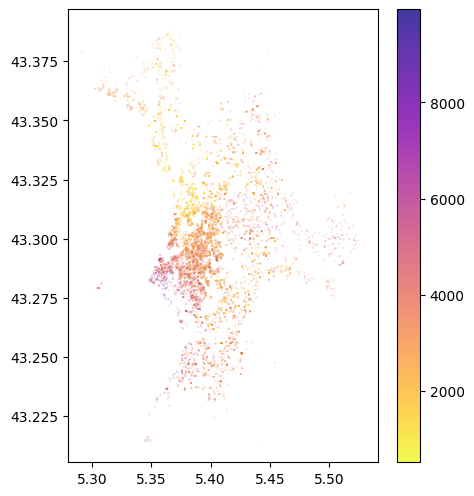

In [29]:
def visualise(df, vmin, vmax):
    
    df_sorted = df.sort_values(by='Prix_m2')
    x = df_sorted['longitude']
    y = df_sorted['latitude']
    c = df_sorted['Prix_m2'] 

    plt.rcParams['figure.figsize'] = [5, 6]
    plt.rcParams['figure.dpi'] = 100 

    plt.scatter(x, y, s=0.01, c=c, cmap='plasma_r', alpha=0.8)
    plt.colorbar()
    plt.show()
    
visualise(df, 200, 1000)

## <center> K plus proches voisins sur la latitude/longitude

In [18]:
df = df.sort_values('date_mutation')

In [45]:
    # Définition du dataset, var explicatives et output
Features = ['latitude', 'longitude']
Label = 'Prix_m2_log'
df_model = df[df.code_type_local == 2]

    # Split des données en TRAIN et TEST
X_train, X_test, y_train, y_test = split_temporel(df_model, Features, Label)

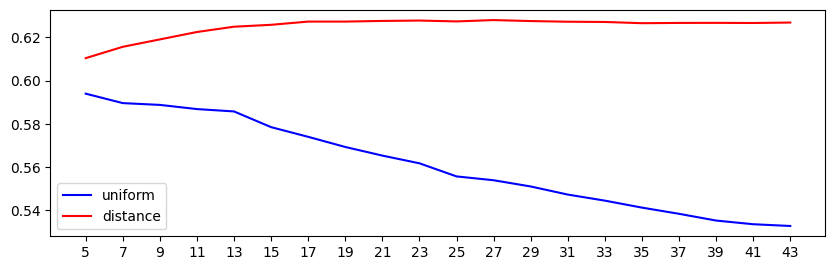

In [48]:
uniform  = []
distance = []
r = range (5,45,2)

for k in r:
    
    # Euclidan, 'straight' distance
    model = KNeighborsRegressor(n_neighbors = k, weights='uniform')
    model.fit(X_train.values, y_train.values)
    uniform.append(model.score(X_test.values,y_test.values))

    # Distance is inversely proportional (to lessen the weight of outliers)
    model = KNeighborsRegressor(n_neighbors = k, weights='distance') 
    model.fit(X_train.values, y_train.values)
    distance.append(model.score(X_test.values,y_test.values))

uniform = np.array(uniform)
distance = np.array(distance)

plt.rcParams['figure.figsize'] = [10, 3]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
plt.plot(r,uniform,label='uniform',color='blue')
plt.plot(r,distance,label='distance',color='red')
plt.legend()
plt.gca().set_xticks(r)
plt.show()

In [50]:
#pd.DataFrame({"k" : r, "uniform" : uniform, "distance" : distance})

La tableau nous indique de prendre 27 voisins.

In [58]:
pipe = Pipeline([('scaler', StandardScaler()), ('Knn', KNeighborsRegressor(weights='distance'))])
parameters = {'Knn__n_neighbors': range(1,29,2)} # defining parameter space
knn_pipe = GridSearchCV(pipe, parameters, cv=5)
knn_pipe.fit(X_train, y_train)

print('Returned hyperparameter: {}'.format(knn_pipe.best_params_))
print('Best classification accuracy in train is: {}'.format(knn_pipe.best_score_))
print('Classification accuracy on test is: {}'.format(knn_pipe.score(X_test, y_test)))

Returned hyperparameter: {'Knn__n_neighbors': 27}
Best classification accuracy in train is: 0.5893392409458341
Classification accuracy on test is: 0.628155505418164
